In [ ]:
from multiprocessing import Pool, Process, cpu_count
max_workers = cpu_count() - 2

config = {
    "base": 0.008,
    "ceil": 80,
    "raise_start": 64,
    "raise_diff" : 0.06
}

def prob(n):
    

with Pool(processes=max_workers) as pool:
    pool.map()

# 


12

   samples_condition_actual7  obs_total_draws  mean_total_draws  \
0                       7651              888        733.766174   

   median_total_draws  std_total_draws  percentile_rank_of_obs_%  
0               737.0        82.454031                 97.856489  


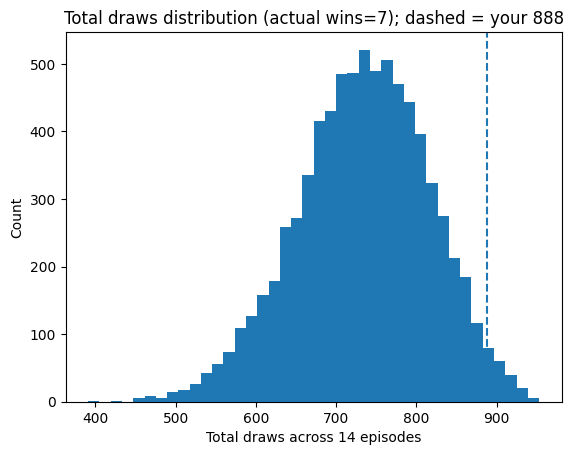

In [10]:
# Monte Carlo to estimate the percentile of total draws given:
# - Per-episode "first success time" T sampled from the same pity schedule used earlier (1..80).
# - 14 episodes total.
# - Odd-indexed episodes (1,3,5,...) require a 50% coin to count as an "actual" win; even-indexed count automatically.
# We filter runs where the number of "actual" wins == 7 (i.e., all 7 odd coins failed).
# For those runs, we compute the percentile of a given observed total-draws sum (888).

import random, bisect, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Build PMF/CDF for pity schedule up to t=80
p = {}
for t in range(1, 81):
    if t <= 63:
        p[t] = 0.008
    else:
        p[t] = min(0.008 + 0.06*(t-63), 1.0)

pmf = []
survival = 1.0
for t in range(1, 81):
    pmf.append(survival * p[t])
    survival *= (1 - p[t])

cdf = np.cumsum(pmf)
support = np.arange(1, 81, dtype=int)

def sample_T(u):
    # inverse CDF
    idx = bisect.bisect_left(cdf, u)
    return int(support[idx])

def simulate_once():
    Ts = [sample_T(random.random()) for _ in range(14)]
    # odd indices (1-based): 1,3,5,...,13 -> 0-based indices 0,2,4,...,12
    actual = 7  # evens always count
    for i in range(0, 14, 2):
        # odd episodes: coin flip, need success to count; user failed all in observed case,
        # but for filtering we require "actual == 7", i.e., all odd flips = 0.
        if random.random() < 0.5:
            actual += 1
    return sum(Ts), actual

N = 1000000
totals = []
for _ in range(N):
    s, actual = simulate_once()
    if actual == 7:
        totals.append(s)

totals = np.array(totals, dtype=int)
obs_total = 888

# Percentile rank: proportion <= obs_total
percentile = (totals <= obs_total).mean() * 100.0

summary = {
    "samples_condition_actual7": int(len(totals)),
    "obs_total_draws": int(obs_total),
    "mean_total_draws": float(np.mean(totals)),
    "median_total_draws": float(np.median(totals)),
    "std_total_draws": float(np.std(totals, ddof=1)),
    "percentile_rank_of_obs_%": float(percentile),
}

# Display summary
df = pd.DataFrame([summary])
print(df.head(6))

# Plot histogram for context
plt.figure()
plt.hist(totals, bins=40)
plt.axvline(obs_total, linestyle="--")
plt.title("Total draws distribution (actual wins=7); dashed = your 888")
plt.xlabel("Total draws across 14 episodes")
plt.ylabel("Count")
plt.show()
